1804


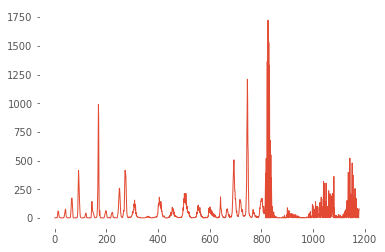

In [54]:
import matplotlib.pyplot as plt
count = 0
total_cases = []
with open("total_data.csv") as f:
    for line in f.readlines():
        #print (line)
        if count ==0:
            count +=1
        else:
            line_split = line.split(",")
            
            if line_split[2] == "50" and len(line_split) >=3:
                total_cases.append(float(line_split[3]))
                
print (len(total_cases))
proc_training_data_base = total_cases[(26*20):(len(total_cases) - 26*4)]
plt.plot(proc_training_data_base)
plt.show()

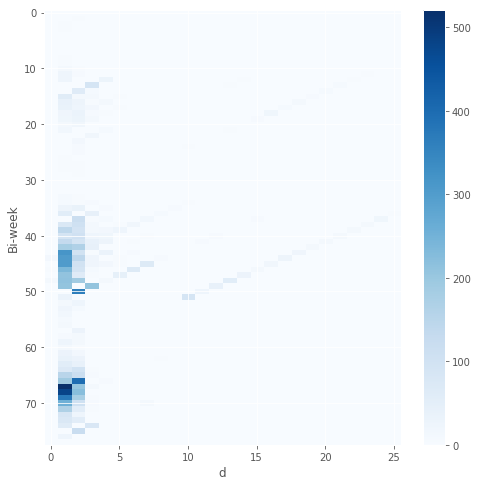

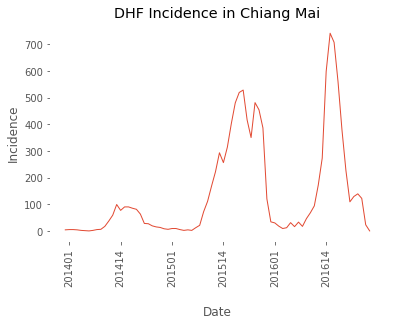

In [55]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1
plt.rcParams['axes.facecolor']='w'

n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "50":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
np.set_printoptions(suppress=True)    #np.set_printoptions(threshold=np.nan)


D=26
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d 

from matplotlib.pyplot import cm


def sim_data(x,y,z):
    return n_t_d[:y]



pos=[]
biweek_x_label = []
for year in ["2014","2015","2016"]:
    for j in np.arange(1,27,13):
        if j <= 9:
               biweek_x_label.append(year + "0"+ str(j))

        else:
               biweek_x_label.append(year +  str(j))
        if year == "2014":
               pos.append(j)
        elif year == "2015":
               pos.append(j+26)
        elif year == "2016":
               pos.append(j+26*2)

from matplotlib.pyplot import cm
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(n_t_d,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

plt.plot(n_t_d.sum(axis=1))
plt.xticks(pos, biweek_x_label, rotation='vertical')
plt.xlabel("\nDate")
plt.title("DHF Incidence in Chiang Mai")
plt.ylabel("Incidence")
plt.show()

In [56]:
def bayes_estimate_prob(po_data,m2,alphas,LO,N_SIM):
    ret_arr = []
    #print (po_data)
    #sys.exit()
    phat = alphas/sum(alphas)
    for row in np.arange(LO,0,-1):

        count = LO
        tmp = []
        for s_ in range(N_SIM):
                p_hat = np.random.dirichlet(alphas,1)[0]
                
                #print (p_hat)
                if po_data[D-row] == 0:
                     with suppress_stdout():
                            
                        process_training_data =[]
                        for d in range(D-row):
                               process_training_data.append(po_data[d]/sum(p_hat[:(D-d)]))
                        #print (process_training_data)
                        myDLM = dlm(process_training_data)
                        #myDLM = myDLM + seasonality(26, name='7day', w=.5)
                        myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
                        myDLM.fit()
                        (process_model_forecast, predictVar) = myDLM.predictN(N=1, date=myDLM.n-1)
                        if process_model_forecast[0]>=0:
                            tmp_n_t_inf = process_model_forecast[0]
                        else:
                            tmp_n_t_inf = 0
                else:                        
                    tmp_n_t_inf = po_data[D-row]/sum(p_hat[:row])
              
                

                tmp.append(np.random.normal(tmp_n_t_inf, 10,size=100))
                #ret_arr.append(po_data[D-row]/sum(phat[:row]))
        count -=1
        ret_arr.append(tmp)
    return ret_arr

In [57]:
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error
from pyramid.arima import ARIMA

import os

rmse_vec_cv = []
#with suppress_stdout():
rmse_vec = []
sim_data_var = []
N_SIM = 100
sim_results_pi = []
sim_results_mse = []
for sim_num in np.arange(30,60):
            sim_n_t_d = sim_data(D,sim_num,False)
            train = sim_n_t_d
            


            train = np.array(train)
            train_n_t_d = train.reshape((-1,D))
            ts = train_n_t_d.sum(axis=1)
            data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]




            delayed_data = []
            count = D
            for i in range(len(data_to_be_scaled_down)):
                tmp = data_to_be_scaled_down[i][:count].tolist()
                while len(tmp) <D:
                    tmp.append(0)
                delayed_data.append(tmp)
                count -=1 


            training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

            k = np.array(train_n_t_d).shape[1 ]
            alphas = np.ones(k)

            for i in range(len(ts)-D):
                alphas += train_n_t_d[i]

            
           
            #######
            # MODEL 1: Delay
            ########
            delay_model_samples = []
            for s_ in range(N_SIM):
                model_1_delay = []
                count = D
                p_vec_noise = np.random.dirichlet(alphas)
                for i in range(len(delayed_data)):
                    delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                    model_1_delay.append(np.round(delay_forecast,2))
                    count -= 1
                delay_model_samples.append(model_1_delay)
            
            delay_model_samples = np.array(delay_model_samples)
            

            #######
            # MODEL 2 : Forecast
            ########
            
            LO=5
            process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
            process_training_data = np.append(proc_training_data_base,process_training_data,axis=0)
            from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
            myDLM = dlm(process_training_data)
            myDLM = myDLM + seasonality(26, name='7day', w=.5)
            myDLM = myDLM + autoReg(degree=3, data=process_training_data, name='ar2', w=1.0)
            myDLM.fit()
            (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)
            
            
            
            #stepwise_model = auto_arima(process_training_data, start_p=1, start_q=1,
            #               max_p=3, max_q=3, m=26,
            #               start_P=0, seasonal=True,
            #               d=1, D=1, trace=True,
            ##               error_action='ignore',  
             #              suppress_warnings=True, 
             #              stepwise=True)
            #process_model_forecast = stepwise_model.predict(n_periods=LO)
           
            predictVar = 1*np.ones(len(process_model_forecast))
            #######
            # MODEL 2
            ########
            forecast_model_samples = []
            for s_ in range(N_SIM):
                model_2_delay = []
                count = D
                for i in np.arange(LO,0,-1):
                    tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                    model_2_delay.append(np.round(tmp,2))
                    count -= 1

                forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))
            
            forecast_model_samples = np.array(forecast_model_samples)
            
                
            model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)
            
            delay_model_samples = np.transpose(np.array(delay_model_samples))
            forecast_model_samples = np.transpose(np.array(forecast_model_samples))
            
            delay_sim_res = delay_model_samples
            fcast_sim_res = forecast_model_samples
            avg_sim_res = model_average
            LO_av = np.array(avg_sim_res).reshape((LO,-1))
            LO_delay = delay_sim_res[D-LO:]
            LO_fcast = fcast_sim_res[D-LO:]
            LO_truth = ts[len(ts)-LO:]
            #print (np.mean(LO_delay,axis=1),np.mean(LO_fcast,axis=1),LO_truth\
                   #,np.mean(LO_av,axis=1))
            #sys.exit()
            sim_results_mse.append([mean_absolute_error(np.mean(LO_delay,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_fcast,axis=1),LO_truth),\
                                   mean_absolute_error(np.mean(LO_av,axis=1),LO_truth)])
            print (sim_results_mse[-1])
            av_cp = 0
            fcast_cp = 0
            delay_cp = 0
            for i in range(LO):
                LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
                LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
                LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
                print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
                if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                    av_cp +=1

                if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                    fcast_cp +=1

                if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                    delay_cp +=1


            av_cp = 1.*av_cp/LO
            fcast_cp = 1.*fcast_cp/LO
            delay_cp = 1.*delay_cp/LO

            print (delay_cp,fcast_cp,av_cp)
            sim_results_pi.append([delay_cp,fcast_cp,av_cp])

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.904660000000003, 31.969659999999994, 10.604811370523956]
(array([11., 21.]), array([-26., -23.]), array([-6., 34.]), 8.0)
(array([ 8., 16.]), array([-40., -37.]), array([-8., 32.]), 6.0)
(array([16., 37.]), array([40., 44.]), array([ 1., 45.]), 9.0)
(array([13., 39.]), array([-33., -29.]), array([-1., 48.]), 9.0)
(array([0., 0.]), array([-7., -3.]), array([-4., 42.]), 5.0)
(0.0, 0.0, 1.0)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.882640000000003, 27.696140000000003, 4.495574717349851]
(array([ 8., 13.]), array([-29., -26.]), array([-10.,  29.]), 6.0)
(array([13., 23.]), array([49., 53.]), array([-3., 37.]), 9.0)
(array([13., 26.]), array([-26., -22.]), array([-2., 40.]), 9.0)
(array([3., 7.]), array([-4., -0.]), array([-15.,  24.]), 5.0)
(array([0., 0.]), array([-23., -20.]), array([-18.

Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[189.8445600000001, 259.62234, 188.96073989005617]
(array([336., 354.]), array([267., 271.]), array([321., 366.]), 314.0)
(array([474., 506.]), array([206., 209.]), array([461., 511.]), 402.0)
(array([649., 714.]), array([184., 188.]), array([644., 731.]), 480.0)
(array([ 858., 1019.]), array([161., 164.]), array([ 839., 1002.]), 519.0)
(array([112., 624.]), array([118., 122.]), array([135., 630.]), 528.0)
(0.2, 0.0, 0.2)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[173.68746000000013, 275.07325999999995, 185.7484394542529]
(array([441., 463.]), array([245., 248.]), array([428., 474.]), 402.0)
(array([509., 540.]), array([229., 232.]), array([498., 551.]), 480.0)
(array([708., 778.]), array([205., 208.]), array([696., 788.]), 519.0)
(array([816., 980.]), array([160., 165.]), array([811., 992.]), 528.0)
(array([ 237., 1378.])

In [58]:
print np.mean(sim_results_pi,axis=0)
sim_results_mse = np.array(sim_results_mse)
print (sim_results_mse)

print np.round(np.mean(sim_results_mse,axis=0))

wins = 0
for i in range(len(sim_results_mse)):
    if sim_results_mse[i][2] < sim_results_mse[i][0]:
        wins +=1
        
print (1.*wins/(len(sim_results_mse)))


[0.13333333 0.02666667 0.58666667]
[[  8.90466     31.96966     10.60481137]
 [  4.88264     27.69614      4.49557472]
 [  5.18578     21.54542      4.49875153]
 [  3.58578     23.63466      2.87347619]
 [  3.95908     13.65152      4.00787155]
 [  8.21502     18.67406      7.11536338]
 [ 18.04056     12.54754     13.56043775]
 [ 25.31402     34.2761       9.55186402]
 [ 41.22352     64.39602     16.5583805 ]
 [ 86.63858    109.42678     68.49693237]
 [104.30386    164.56508     53.72582374]
 [156.381      212.22102    255.66233488]
 [107.1638     222.1534      64.21528344]
 [117.9616     248.27844     46.85950568]
 [139.0823     251.19876     74.4301696 ]
 [423.87678    210.66582    426.59031282]
 [189.84456    259.62234    188.96073989]
 [173.68746    275.07326    185.74843945]
 [145.6204     134.02186    147.0716143 ]
 [352.63926     54.95436    352.86330344]
 [151.99024    110.05408    131.48615531]
 [117.60212    137.63672    123.40478356]
 [136.6517     108.01588    136.95282675]

In [17]:
from scipy.special import expit
import matplotlib.pyplot as pltq

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

cv_mse = []
season_data = []
sim_results_mse = []
sim_results_pi = []
for i in range(3):
    season_data.append(reporting_matrix[i:(i+26)])
    
season_data = np.array(season_data).reshape((3,-1,26))

print (season_data.shape)

for season_for_leave_out in np.arange(3):
        sim_n_t_d = season_data#[:cutoff]

        train = [sim_n_t_d[x] for x in range(3) if x not in [season_for_leave_out]]
        test = sim_n_t_d[season_for_leave_out]
        
        train = np.array(train)
        train_n_t_d = train.reshape((-1,D))
        ts = train_n_t_d.sum(axis=1)

        data_to_be_scaled_down  = test[len(test)-D:]
       
        delayed_data = []
        count = D
        for i in range(len(data_to_be_scaled_down)):
            tmp = data_to_be_scaled_down[i][:count].tolist()
            while len(tmp) <D:
                tmp.append(0)
            delayed_data.append(tmp)
            count -=1 


        training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

        k = np.array(train_n_t_d).shape[1 ]
        alphas = np.ones(k)

        for i in range(len(ts)-D):
            alphas += train_n_t_d[i]



        #######
        # MODEL 1: Delay
        ########
        delay_model_samples = []
        for s_ in range(N_SIM):
            model_1_delay = []
            count = D
            p_vec_noise = np.random.dirichlet(alphas)
            for i in range(len(delayed_data)):
                delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
                model_1_delay.append(np.round(delay_forecast,2))
                count -= 1
            delay_model_samples.append(model_1_delay)

        delay_model_samples = np.array(delay_model_samples)


        #######
        # MODEL 2 : Forecast
        ########

        LO=5
        process_training_data = np.append(ts[:len(ts)-D],model_1_delay[:D-LO],axis=0)
        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(process_training_data)
       # myDLM = myDLM + seasonality(26, name='7day', w=1.0)
        myDLM = myDLM + autoReg(degree=2, data=process_training_data, name='ar2', w=1.0)
        myDLM.fit()
        (process_model_forecast, predictVar) = myDLM.predictN(N=LO, date=myDLM.n-1)

        #######
        # MODEL 2
        ########
        forecast_model_samples = []
        for s_ in range(N_SIM):
            model_2_delay = []
            count = D
            for i in np.arange(LO,0,-1):
                tmp = np.random.normal(process_model_forecast[LO-i],np.sqrt(predictVar[LO-i]))
                model_2_delay.append(np.round(tmp,2))
                count -= 1

            forecast_model_samples.append(np.append(model_1_delay[:D-LO],model_2_delay))

        forecast_model_samples = np.array(forecast_model_samples)


        model_average = bayes_estimate_prob(np.sum(delayed_data,axis=1),forecast_model_samples,alphas,LO,N_SIM)

        model_average = np.transpose(np.array(model_average).reshape((-1,LO)))
        delay_model_samples = np.transpose(np.array(delay_model_samples))
        forecast_model_samples = np.transpose(np.array(forecast_model_samples))

        delay_sim_res = delay_model_samples
        fcast_sim_res = forecast_model_samples
        avg_sim_res = model_average
        LO_av = avg_sim_res
        LO_delay = delay_sim_res[D-LO:]
        LO_fcast = fcast_sim_res[D-LO:]
        LO_truth = ts[len(ts)-LO:]

        sim_results_mse.append([mean_squared_error(np.mean(LO_delay,axis=1),LO_truth),\
                               mean_squared_error(np.mean(LO_fcast,axis=1),LO_truth),\
                               mean_squared_error(np.mean(LO_av,axis=1),LO_truth)])
        print (sim_results_mse[-1])
        av_cp = 0
        fcast_cp = 0
        delay_cp = 0
        for i in range(LO):
            LO_av_ci = np.round(np.percentile(LO_av[i],[2.5,97.5]))
            LO_fcast_ci = np.round(np.percentile(LO_fcast[i],[2.5,97.5]))
            LO_delay_ci = np.round(np.percentile(LO_delay[i],[2.5,97.5]))
            print (LO_delay_ci,LO_fcast_ci,LO_av_ci, LO_truth[i])
            if LO_av_ci[0] <= LO_truth[i] <= LO_av_ci[1]:
                av_cp +=1

            if LO_fcast_ci[0] <= LO_truth[i] <= LO_fcast_ci[1]:
                fcast_cp +=1

            if LO_delay_ci[0] <= LO_truth[i] <= LO_delay_ci[1]:
                delay_cp +=1


        av_cp = 1.*av_cp/LO
        fcast_cp = 1.*fcast_cp/LO
        delay_cp = 1.*delay_cp/LO

        print (delay_cp,fcast_cp,av_cp)
        sim_results_pi.append([delay_cp,fcast_cp,av_cp])

(3, 78, 26)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


[325627.8522973311, 31451.487937133505, 23743.425214048777]
(array([1189., 1346.]), array([-198.,  209.]), array([ -0., 147.]), 287.0)
(array([0., 0.]), array([-196.,  207.]), array([ -0., 147.]), 0.0)
(array([0., 0.]), array([-213.,  218.]), array([ -0., 147.]), 0.0)
(array([ 960., 1261.]), array([-209.,  210.]), array([ -0., 147.]), 278.0)
(array([0., 0.]), array([-199.,  212.]), array([ -0., 147.]), 1.0)
(0.4, 0.6, 0.6)
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[15459.1863900645, 31923.139478738594, 27066.49213265992]
(array([266., 303.]), array([-245.,  228.]), array([ -0., 136.]), 287.0)
(array([0., 0.]), array([-216.,  252.]), array([ -0., 137.]), 0.0)
(array([0., 0.]), array([-225.,  226.]), array([ -0., 137.]), 0.0)
(array([0., 0.]), array([-249.,  245.]), array([ -0., 136.]), 278.0)
(array([0., 0.]), array([-227.,  220.]), array([ -0., 137.]), 1.0)
(0.6, 0.6, 0.6)
Starting forward filtering...
Forward

In [18]:

#### sim_results_pi = np.array(sim_results_pi)#### sim 
print np.mean(sim_results_pi,axis=0)

sim_results_mse = np.array(sim_results_mse)
print np.round(np.mean(sim_results_mse,axis=0)/1)

[0.46666667 0.66666667 0.66666667]
[435247.  26757.  21165.]
